In [10]:
import os
from loaddata import load_graph_and_matrices, load_nodes_and_edges
from graph_plot_utils import define_graph_attributes
import networkx as nx
import matplotlib.pyplot as plt
from draw_meta_network import load_communities
import plot_params
from loaddata import get_name_from_rootid
import pandas as pd
import numpy as np


In [11]:
nodes,edges = load_nodes_and_edges()

In [12]:
(
        _,
        _,
        unn_matrix,
        _,
        equiv_index_rootid,
    ) = load_graph_and_matrices("dn")
equiv_index_rootid

,index,root_id
0,0,720575940602534112
1,1,720575940602864300
2,2,720575940603489824
3,3,720575940603580960
4,4,720575940603591014
...,...,...
1271,1271,720575940659703937
1272,1272,720575940660220289
1273,1273,720575940660224385
1274,1274,720575940660229505


# Strongest broadcaster neurons

In [13]:
# Build a table with all descending neurons, sorted from the most outputs to the least.
# Each row is a neuron
# The columns are: root_id, name, cluster it belongs to, number of outputs,
# number of inputs, neurotransmitter type,
# how many neurons it connects to in each cluster (one column per cluster)

dn_data = pd.read_csv(
    os.path.join(plot_params.CLUSTERING_ARGS['data_folder'], 'clustering.csv')
    , index_col=0)
dn_data.sort_values(by='node_index', inplace=True)
dn_data.reset_index(inplace=True, drop=True)
dn_data

,node_index,root_id,cluster,name
0,0,720575940602534112,22,DNge116
1,1,720575940602864300,124,DNpe008
2,2,720575940603489824,26,DNpe015
3,3,720575940603580960,125,DNpe054
4,4,720575940603591014,22,DNae006
...,...,...,...,...
1271,1271,720575940659703937,6,DNg18
1272,1272,720575940660220289,0,DNge143
1273,1273,720575940660224385,27,DNg10
1274,1274,720575940660229505,2,DNg31


In [14]:
dn_nodes = nodes[nodes['super_class']== 'descending']
dn_nodes

,root_id,group,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,oct_avg,...,hemibrain_type_strict,hemibrain_type_loose,hemibrain_type_mult,cell_type_strict,cell_type_loose,cell_type_mult,label_strict,label_loose,label_mult,name_taken
69,720575940602534112,GNG,NaN,-1.00,0.05,0.41,0.04,0.17,0.32,0.01,...,NaN,NaN,NaN,NaN,DNge116,NaN,NaN,NaN,NaN,DNge116
95,720575940602864300,IPS,DA,0.89,0.89,0.04,0.02,0.02,0.02,0.01,...,NaN,NaN,NaN,NaN,DNpe008,NaN,NaN,NaN,NaN,DNpe008
224,720575940603489824,IPS,SER,0.50,0.10,0.50,0.03,0.02,0.35,0.00,...,NaN,NaN,NaN,NaN,DNpe015,NaN,NaN,NaN,NaN,DNpe015
266,720575940603580960,IPS.GNG,ACH,0.48,0.07,0.29,0.10,0.06,0.48,0.01,...,DNp16,DNp16,DNp16/17,NaN,DNpe054,NaN,NaN,NaN,NaN,DNpe054
269,720575940603591014,SPS.GNG,ACH,0.67,0.06,0.16,0.03,0.06,0.67,0.01,...,DNa05,DNa05,NaN,NaN,DNae006,NaN,NaN,NaN,NaN,DNae006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127640,720575940659703937,IPS.GNG,GLUT,0.55,0.03,0.03,0.23,0.55,0.16,0.00,...,NaN,NaN,NaN,DNg18,DNg18,NaN,NaN,NaN,NaN,DNg18
127773,720575940660220289,GNG,NaN,-1.00,0.02,0.03,0.43,0.33,0.19,0.00,...,NaN,NaN,NaN,NaN,DNge143,NaN,NaN,NaN,NaN,DNge143
127775,720575940660224385,GNG,NaN,-1.00,0.02,0.05,0.31,0.24,0.38,0.00,...,NaN,NaN,NaN,DNg10,DNg10,NaN,NaN,NaN,NaN,DNg10
127778,720575940660229505,GNG,NaN,-1.00,0.06,0.07,0.29,0.21,0.26,0.12,...,NaN,NaN,NaN,DNg31,DNg31,NaN,NaN,NaN,NaN,DNg31


In [15]:
import params
inferred_names = pd.read_csv(os.path.join(
    params.GRAPHS_DIR,
    "inferred_names.csv"
))
# list the root ids and 'name_taken' of inferred names not in the dn_data
inferred_names[~inferred_names['root_id'].isin(dn_data['root_id'])][['root_id', 'name_taken']]


,root_id,name_taken
41,720575940606756309,DNpe018
89,720575940610440402,DNge085
136,720575940612014131,DNg02
154,720575940612429743,DNge074
193,720575940613998860,DNg03
294,720575940617035449,DNge074
333,720575940617873201,DNpe051
367,720575940618548244,DNge066
380,720575940618863553,DNge061
402,720575940619372726,DNge114


In [16]:
working_folder = plot_params.CLUSTERING_ARGS["folder"]
data_folder = plot_params.CLUSTERING_ARGS["data_folder"]
communities = load_communities(
    data_folder,
    return_type="list",
    data_type="root_id",
    threshold = plot_params.CLUSTERING_ARGS["confusion_mat_size_threshold"],
    )
# add an empty column to the dn_data table
dn_data['paper_cluster'] = np.NaN
for count, c_ in enumerate(communities):
    for root_id in c_:
        dn_data.loc[dn_data['root_id'] == root_id, 'paper_cluster'] = count
dn_data



,node_index,root_id,cluster,name,paper_cluster
0,0,720575940602534112,22,DNge116,8.0
1,1,720575940602864300,124,DNpe008,NaN
2,2,720575940603489824,26,DNpe015,NaN
3,3,720575940603580960,125,DNpe054,NaN
4,4,720575940603591014,22,DNae006,8.0
...,...,...,...,...,...
1271,1271,720575940659703937,6,DNg18,3.0
1272,1272,720575940660220289,0,DNge143,0.0
1273,1273,720575940660224385,27,DNg10,NaN
1274,1274,720575940660229505,2,DNg31,2.0


# Focus on the neurons bridging walking and grooming clusters

In [17]:
for count, c_ in enumerate(communities):
    print("===== Communnity: ", count)
    print(len(c_))
    print([get_name_from_rootid(x) for x in c_])

===== Communnity:  0
120


['DNde007', 'DNg10', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg12', 'DNg17', 'DNg17', 'DNg21', 'DNg21', 'DNg22', 'DNge001', 'DNge001', 'DNge001', 'DNge001', 'DNge009', 'DNge009', 'DNge011', 'DNge011', 'DNge012', 'DNge012', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge019', 'DNge020', 'DNge020', 'DNge020', 'DNge020', 'DNge020', 'DNge020', 'DNge020', 'DNge021', 'DNge022', 'DNge022', 'DNge024', 'DNge024', 'DNge025', 'DNge025', 'DNge027', 'DNge027', 'DNge039', 'DNge039', 'DNge044', 'DNge044', 'DNge048', 'DNge082', 'DNge082', 'DNge122', 'DNge122', 'DNge142', 'DNge142', 'DNge143', 'DNge143', 'DNge144', 'D

In [18]:
# walking cluster nb: 
walking_cluster_nb = 2
walking_cluster = communities[walking_cluster_nb]
# grooming cluster nb:
grooming_cluster_nb = 0
grooming_cluster = communities[grooming_cluster_nb]

In [19]:
# Define a dictionary with the neurons in the grooming and walking clusters
# The keys are  the root_id, and the values are a dictionary with the name and the cluster
relevant_neurons = {}
for n in walking_cluster:
    relevant_neurons[n] = {
        "name": get_name_from_rootid(n),
        "cluster": "walking",
        "color": 'yellow',
        "root_id": n,
        }
for n in grooming_cluster:
    relevant_neurons[n] = {
        "name": get_name_from_rootid(n),
        "cluster": "grooming",
        "color": 'blue',
        "root_id": n,
        }

connections = edges[edges['pre_root_id'].isin(relevant_neurons.keys()) | edges['post_root_id'].isin(relevant_neurons.keys())]
graph, network_specs = define_graph_attributes(connections, relevant_neurons)


In [20]:
walking_graph, _ = define_graph_attributes(
    connections[connections['pre_root_id'].isin(walking_cluster) & connections['post_root_id'].isin(walking_cluster)],
    relevant_neurons
    )
grooming_graph, _ = define_graph_attributes(
    connections[connections['pre_root_id'].isin(grooming_cluster) & connections['post_root_id'].isin(grooming_cluster)],
    relevant_neurons
    )

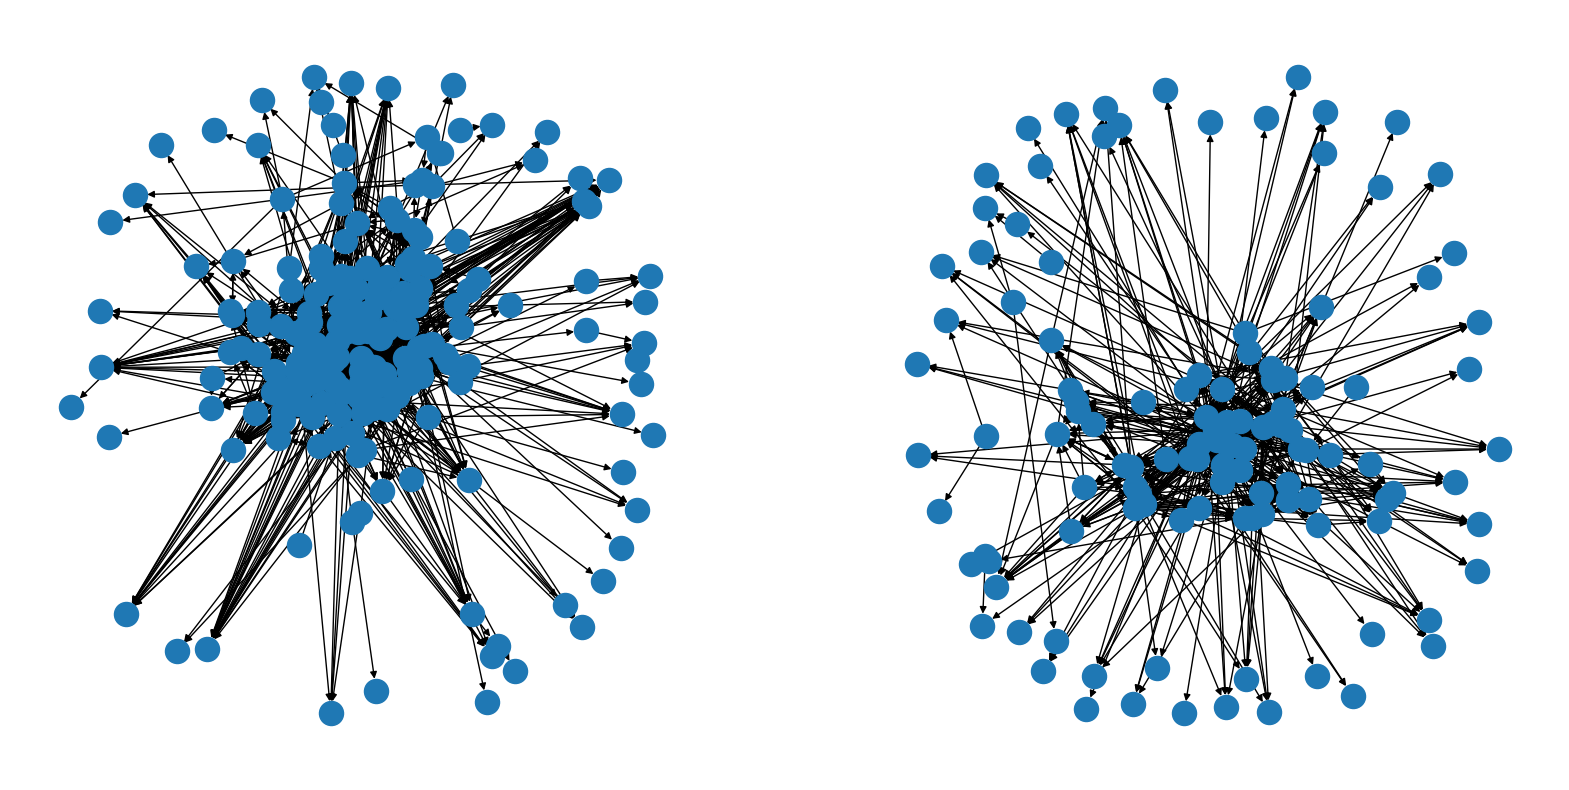

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
nx.draw(walking_graph, ax=ax[0], pos=nx.spring_layout(walking_graph))
nx.draw(grooming_graph, ax=ax[1], pos=nx.spring_layout(grooming_graph))

KeyboardInterrupt: 

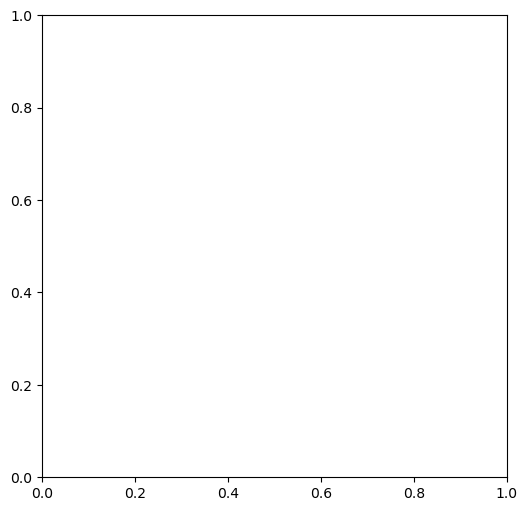

In [22]:
fig, ax = plt.subplots(figsize=(6,6))

nx.draw(
    graph,
    ax=ax,
    node_size=10,
    node_color=[graph.nodes[n]['node_color'] for n in graph.nodes],
    edge_color='grey',
    width=0.1,
    pos=nx.spring_layout(graph),
    )

In [ ]:
# 'eff_weight'

from_walk_to_groom = edges[
    (edges['pre_root_id'].isin(walking_cluster)
    & edges['post_root_id'].isin(grooming_cluster)
    & (edges['eff_weight'] < 0))
    ]
from_walk_to_groom

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,eff_weight,syn_count_norm,eff_weight_norm
707924,720575940615715003,720575940623426854,GNG,14,GLUT,-14,0.017812,-0.017812
2324667,720575940627465298,720575940626813502,GNG,6,GLUT,-6,0.002733,-0.002733
1725795,720575940623338281,720575940629806974,GNG,67,GABA,-67,0.063749,-0.063749
2824309,720575940630810486,720575940629806974,GNG,53,GABA,-53,0.050428,-0.050428
1725810,720575940623338281,720575940632302151,GNG,20,GABA,-20,0.078431,-0.078431
...,...,...,...,...,...,...,...,...
2824217,720575940630810486,720575940612376805,GNG,107,GABA,-107,0.484163,-0.484163
2824324,720575940630810486,720575940632355885,GNG,5,GABA,-5,0.046729,-0.046729
1084160,720575940619077755,720575940618762605,GNG,6,GLUT,-6,0.063830,-0.063830
1725724,720575940623338281,720575940618762605,GNG,5,GABA,-5,0.053191,-0.053191
